<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/Burn/data_augmentation/burn_MixUp_CutMix_RICAP_60epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CutMix, MixUp and  RICAP Data Augmentation and Training on Burn Dataset

We summarize below a comparison of variousn SOtA data-augmentation  techniques (CutMix, MixUp, RICAP) as applied to the burn data set. [CutMix](https://arxiv.org/abs/1905.04899) augmentation strategy, where image patches are cut and pasted among training images and the ground truth labels are  mixed proportionally to the area of the patches, is reported to result in consistent performance gains in CIFAR, ImageNet etc datasets and  be more robust for out-of-distribution detections tasks. 


PS: open in colab to see the whole notebook including the last summary part.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import time
import os
import sys
import importlib.util
from pathlib import Path
from google.colab import drive

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models import *


import numpy as np
import matplotlib.pyplot as plt


print("Fastai Version: ",fastai.__version__)

Fastai Version:  1.0.55


In [0]:
# Top level data directory. 

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
sys.path.append('/content/gdrive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = Path('/content/drive/My Drive/burn/burn_nosplit_final/')
path.ls()

[PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/1'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/2'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/3'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/none'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/models'),
 PosixPath('/content/drive/My Drive/burn/burn_nosplit_final/burn_model_TL_imagenet.pth')]

In [0]:
import time 
start = time.time()
print(start)

1564026648.2636514


## Training and Predictions : ResNet34


In [0]:
tfms = get_transforms(flip_vert=True)
np.random.seed(0)
data1 = ImageDataBunch.from_folder(path, valid_pct=0.3, ds_tfms=tfms, size=224).normalize(imagenet_stats) 

Classes:  ['1', '2', '3', 'none']


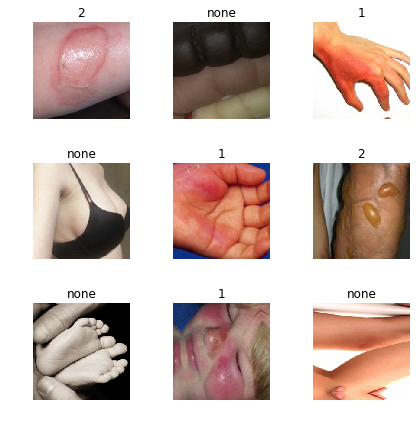

In [0]:
data1.show_batch(rows=3, figsize=(6, 6))
print('Classes: ',data1.classes)

In [0]:
learn_1 = cnn_learner(data1, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 96768339.48it/s] 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


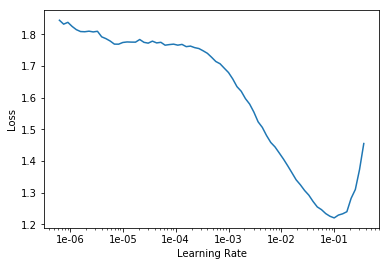

In [0]:
learn_1.lr_find()
learn_1.recorder.plot()

In [0]:
learn_1.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1a')])

epoch,train_loss,valid_loss,accuracy,time
0,1.659455,1.145743,0.531532,01:33
1,1.432420,0.914554,0.639640,00:11
2,1.239859,0.797715,0.693694,00:11
3,1.106080,0.738214,0.729730,00:11
4,1.008649,0.696670,0.747748,00:11
5,0.918373,0.667368,0.729730,00:11
6,0.848653,0.658861,0.743243,00:11
7,0.778812,0.646500,0.765766,00:11
8,0.709629,0.662683,0.770270,00:11
9,0.665446,0.675509,0.752252,00:11


Better model found at epoch 0 with accuracy value: 0.5315315127372742.
Better model found at epoch 1 with accuracy value: 0.6396396160125732.
Better model found at epoch 2 with accuracy value: 0.6936936974525452.
Better model found at epoch 3 with accuracy value: 0.7297297120094299.
Better model found at epoch 4 with accuracy value: 0.7477477192878723.
Better model found at epoch 7 with accuracy value: 0.7657657861709595.
Better model found at epoch 8 with accuracy value: 0.7702702879905701.
Better model found at epoch 20 with accuracy value: 0.7792792916297913.


In [0]:
a = accuracy(*learn_1.get_preds())
print(a)

tensor(0.7793)


In [0]:
learn_1.save('burn_nosplit_final_defaultm')

In [0]:
# learn_1.unfreeze()

In [0]:
# learn_1.fit_one_cycle(60, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_1, every='improvement', monitor='accuracy', name='best_1a')])

In [0]:
# a_unf = accuracy(*learn_1.get_preds())
# print(a_unf)

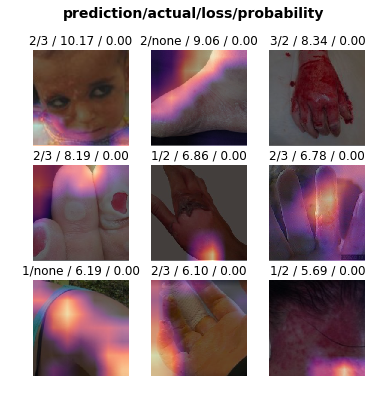

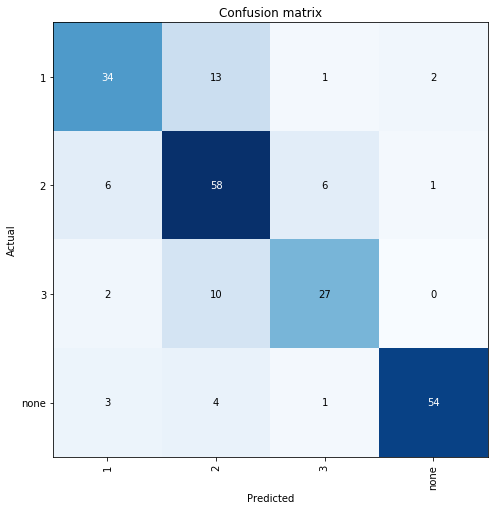

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_1)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

## Training and Predictions : ResNet34 with mixup


In [0]:
learn_2 = cnn_learner(data1, models.resnet34, metrics=accuracy).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


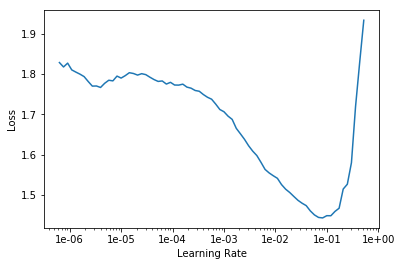

In [0]:
learn_2.lr_find()
learn_2.recorder.plot()

In [0]:
learn_2.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_2, every='improvement', monitor='accuracy', name='best_2b')])

epoch,train_loss,valid_loss,accuracy,time
0,1.599613,1.128765,0.500000,00:11
1,1.446954,0.929031,0.590090,00:11
2,1.352531,0.812746,0.653153,00:11
3,1.280509,0.731643,0.702703,00:11
4,1.232595,0.686589,0.752252,00:11
5,1.167025,0.651496,0.756757,00:11
6,1.124379,0.646324,0.734234,00:11
7,1.088903,0.646436,0.756757,00:11
8,1.062425,0.603281,0.756757,00:11
9,1.028037,0.597339,0.779279,00:11


Better model found at epoch 0 with accuracy value: 0.5.
Better model found at epoch 1 with accuracy value: 0.5900900959968567.
Better model found at epoch 2 with accuracy value: 0.6531531810760498.
Better model found at epoch 3 with accuracy value: 0.7027027010917664.
Better model found at epoch 4 with accuracy value: 0.7522522807121277.
Better model found at epoch 5 with accuracy value: 0.7567567825317383.
Better model found at epoch 9 with accuracy value: 0.7792792916297913.
Better model found at epoch 12 with accuracy value: 0.7972972989082336.
Better model found at epoch 23 with accuracy value: 0.815315306186676.
Better model found at epoch 39 with accuracy value: 0.8243243098258972.


In [0]:
b = accuracy(*learn_2.get_preds())
print(b)

tensor(0.8243)


In [0]:
learn_2.save('burn_nosplit_final_mixup')

In [0]:
# learn_2.unfreeze()

In [0]:
# learn_2.fit_one_cycle(60, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_2, every='improvement', monitor='accuracy', name='best_2b')])

In [0]:
# b_unf = accuracy(*learn_2.get_preds())
# print(b_unf)

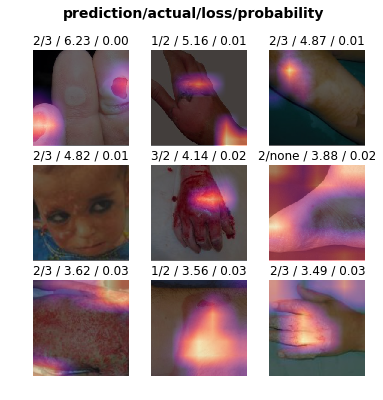

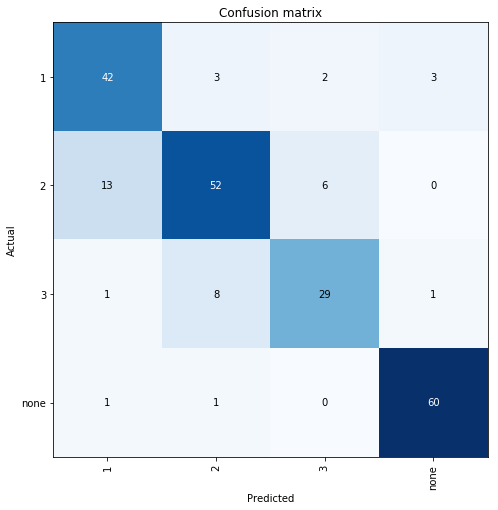

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_2)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

## Training and Predictions : ResNet34 with cutmix


In [0]:
# CutMix 

#adapted from https://github.com/oguiza/fastai_extensions

from fastai.torch_core import *
from fastai.callback import *
from fastai.callbacks.mixup import MixUpLoss
from fastai.basic_train import Learner, LearnerCallback

class CutMixCallback(LearnerCallback):
    "Callback that creates the cutmixed input and target."
    def __init__(self, learn:Learner, α:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.α,self.stack_y,self.true_λ = α,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.α, self.α)
        λ = max(λ, 1- λ)
        shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
        x1, y1 = last_input[shuffle], last_target[shuffle]
        #Get new input
        last_input_size = last_input.shape
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input.size(), λ)
        new_input = last_input.clone()
        new_input[:, ..., bby1:bby2, bbx1:bbx2] = last_input[shuffle, ..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        if self.true_λ:
            λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
            λ = last_input.new([λ])
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)
        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, α:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add mixup https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, α=α, stack_y=stack_y, true_λ=true_λ))
    return learn

Learner.cutmix = cutmix

In [0]:
#code to show augmented image data

def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn


Learner.show_multi_img_tfms = show_multi_img_tfms


def show_single_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn

def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn

def show_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    rand_int = np.random.randint(len(xb))
    rand_img = Image(xb[rand_int])
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    cb_tfms = 0
    for cb in learn.callback_fns:
        if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
            cb_fn = partial(get_fn(cb), **cb.keywords)
            try:
                fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
                plt.suptitle(get_fn(cb).__name__, size=14)
                [Image(cb_fn(learn).on_batch_begin(
                            xb, yb, True)['last_input'][0]).show(ax=ax)
                    for i, ax in enumerate(fig)]
                plt.show()
                cb_tfms += 1
                break
            except:
                plt.close('all')
    if cb_tfms == 0:
        if tfms is not None:
            t_ = []
            for t in learn.data.train_ds.tfms: t_.append(get_fn(t).__name__)
            title = f"{str(t_)[1:-1]} transforms applied"
        else: title = f'No transform applied'
        rand_int = np.random.randint(len(xb))
        fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
        plt.suptitle(title, size=14)
        [rand_img.apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(fig)]
        plt.show()
    return learn

Learner.show_tfms = show_tfms
Learner.show_multi_img_tfms = show_multi_img_tfms
Learner.show_single_img_tfms = show_single_img_tfms

In [0]:
learn_3 = cnn_learner(data1, models.resnet34, metrics=accuracy).cutmix()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


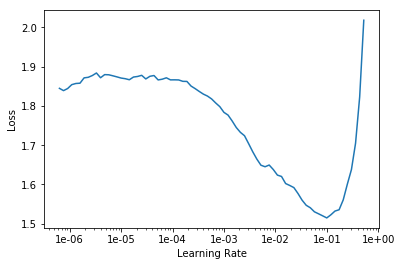

In [0]:
learn_3.lr_find()
learn_3.recorder.plot()

In [0]:
learn_3.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_3, every='improvement', monitor='accuracy', name='best_3c')])

epoch,train_loss,valid_loss,accuracy,time
0,1.759136,1.225877,0.459459,00:11
1,1.612494,0.991360,0.635135,00:11
2,1.449624,0.858027,0.666667,00:11
3,1.375506,0.772515,0.693694,00:11
4,1.301298,0.737977,0.702703,00:11
5,1.241368,0.684034,0.725225,00:11
6,1.195966,0.700852,0.729730,00:11
7,1.163079,0.723960,0.693694,00:11
8,1.140059,0.705399,0.698198,00:11
9,1.094567,0.655775,0.729730,00:11


Better model found at epoch 0 with accuracy value: 0.45945945382118225.
Better model found at epoch 1 with accuracy value: 0.6351351141929626.
Better model found at epoch 2 with accuracy value: 0.6666666865348816.
Better model found at epoch 3 with accuracy value: 0.6936936974525452.
Better model found at epoch 4 with accuracy value: 0.7027027010917664.
Better model found at epoch 5 with accuracy value: 0.7252252101898193.
Better model found at epoch 6 with accuracy value: 0.7297297120094299.
Better model found at epoch 10 with accuracy value: 0.7432432174682617.
Better model found at epoch 11 with accuracy value: 0.7567567825317383.
Better model found at epoch 15 with accuracy value: 0.7747747898101807.
Better model found at epoch 16 with accuracy value: 0.792792797088623.
Better model found at epoch 17 with accuracy value: 0.7972972989082336.
Better model found at epoch 25 with accuracy value: 0.8063063025474548.


In [0]:
c = accuracy(*learn_3.get_preds())
print(c)

tensor(0.8063)


In [0]:
learn_3.save('burn_nosplit_final_mixup')

In [0]:
# learn_3.unfreeze()

In [0]:
# learn_3.fit_one_cycle(60, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_3, every='improvement', monitor='accuracy', name='best_3c')])

In [0]:
# c_unf = accuracy(*learn_3.get_preds())
# print(c_unf)

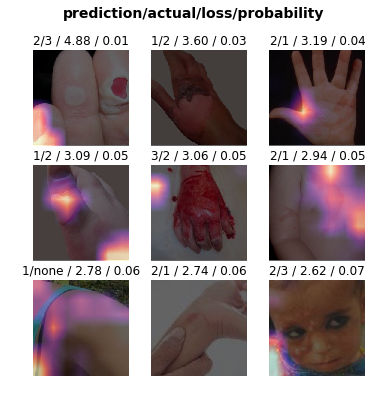

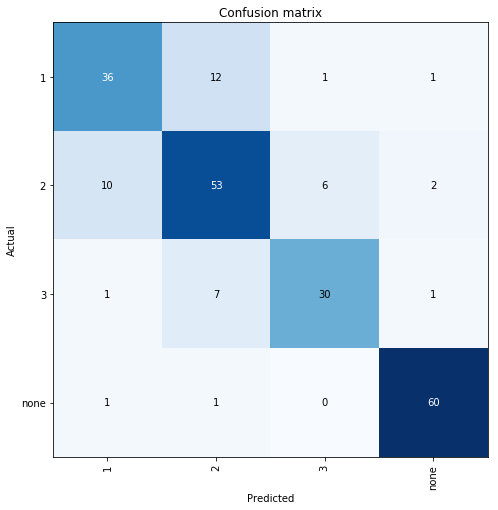

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_3)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

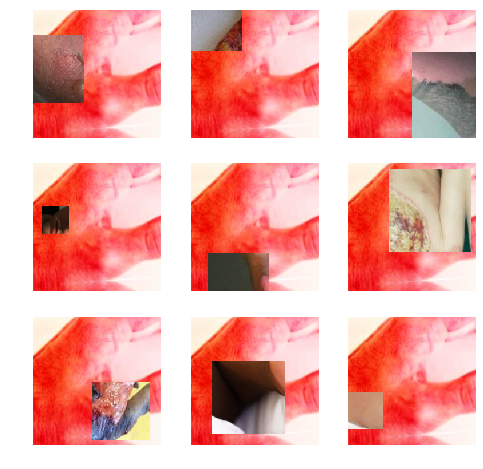

Learner(data=ImageDataBunch;

Train: LabelList (520 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/burn/burn_nosplit_final;

Valid: LabelList (222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,1,1,3
Path: /content/drive/My Drive/burn/burn_nosplit_final;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [0]:
learn_3.show_multi_img_tfms()

## Training and Predictions : ResNet34 with RICAP
(Random Image Cropping and Patching)


In [0]:
# RICAP 

# code adapted from https://github.com/oguiza/fastai_extensions

class RicapLoss(nn.Module):
    "Adapt the loss function `crit` to go with ricap data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:
            c_ = target[:, 1:5]
            W_ = target[:, 5:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(4)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class RicapCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1811.09030
    github: https://github.com/4uiiurz1/pytorch-ricap
    and mixup in the fastai library.'''
    def __init__(self, learn:Learner, beta:float=.3, stack_y:bool=True):
        super().__init__(learn)
        self.beta,self.stack_y = beta,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = RicapLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies ricap to `last_input` and `last_target` if `train`."
        if not train: return

        # get the image size
        I_x, I_y = last_input.size()[2:]

        # draw a boundary position (w, h)
        w = int(np.round(I_x * np.random.beta(self.beta, self.beta)))
        h = int(np.round(I_y * np.random.beta(self.beta, self.beta)))
        w_ = [w, I_x - w, w, I_x - w]
        h_ = [h, h, I_y - h, I_y - h]

        # select and crop four images
        cropped_images = {}
        bs = last_input.size(0)
        c_ = torch.zeros((bs, 4)).float().to(last_input.device)
        W_ = torch.zeros(4).float().to(last_input.device)
        for k in range(4):
            idx = torch.randperm(bs).to(last_input.device)
            x_k = np.random.randint(0, I_x - w_[k] + 1)
            y_k = np.random.randint(0, I_y - h_[k] + 1)
            cropped_images[k] = last_input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
            c_[:, k] = last_target[idx].float()
            W_[k] = w_[k] * h_[k] / (I_x * I_y)

        # patch cropped images
        patched_images = torch.cat(
            (torch.cat((cropped_images[0], cropped_images[1]), 2),
             torch.cat((cropped_images[2], cropped_images[3]), 2)), 3).to(last_input.device)

        # modify last target
        if self.stack_y:
                new_target = torch.cat((last_target[:,None].float(), c_,
                                        W_[None].repeat(last_target.size(0), 1)), dim=1)
        else:
            new_target = c_ * W_

        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def ricap(learn:Learner, beta:float=.3, stack_y:bool=True) -> Learner:
    "Add ricap https://arxiv.org/pdf/1811.09030.pdf to `learn`."
    learn.callback_fns.append(partial(RicapCallback, beta=beta, stack_y=stack_y))
    return learn

setattr(ricap, 'cb_fn', RicapCallback)
Learner.ricap = ricap

In [0]:
learn_4 = cnn_learner(data1, models.resnet34, metrics=accuracy).ricap()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


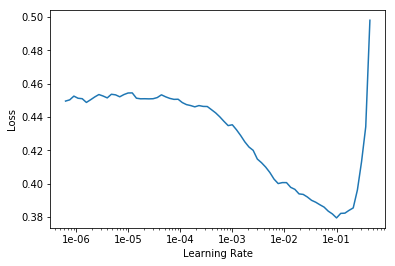

In [0]:
learn_4.lr_find()
learn_4.recorder.plot()

In [0]:
learn_4.fit_one_cycle(60, 1e-2, pct_start=0.5, callbacks=[SaveModelCallback(learn_4, every='improvement', monitor='accuracy', name='best_3c')])

epoch,train_loss,valid_loss,accuracy,time
0,0.423542,1.216043,0.481982,00:11
1,0.391931,0.991019,0.585586,00:11
2,0.365387,0.851511,0.671171,00:11
3,0.343766,0.765511,0.698198,00:11
4,0.345667,0.725813,0.702703,00:11
5,0.335418,0.682947,0.725225,00:11
6,0.322136,0.640253,0.765766,00:11
7,0.304689,0.607717,0.783784,00:11
8,0.298975,0.621633,0.752252,00:11
9,0.295264,0.630186,0.752252,00:11


Better model found at epoch 0 with accuracy value: 0.4819819927215576.
Better model found at epoch 1 with accuracy value: 0.5855855941772461.
Better model found at epoch 2 with accuracy value: 0.6711711883544922.
Better model found at epoch 3 with accuracy value: 0.6981981992721558.
Better model found at epoch 4 with accuracy value: 0.7027027010917664.
Better model found at epoch 5 with accuracy value: 0.7252252101898193.
Better model found at epoch 6 with accuracy value: 0.7657657861709595.
Better model found at epoch 7 with accuracy value: 0.7837837934494019.
Better model found at epoch 20 with accuracy value: 0.7882882952690125.
Better model found at epoch 22 with accuracy value: 0.815315306186676.
Better model found at epoch 46 with accuracy value: 0.8198198080062866.
Better model found at epoch 51 with accuracy value: 0.8243243098258972.
Better model found at epoch 55 with accuracy value: 0.8288288116455078.


In [0]:
d = accuracy(*learn_4.get_preds())
print(d)

tensor(0.8288)


In [0]:
learn_4.save('burn_nosplit_final_mixup')

In [0]:
# learn_4.unfreeze()

In [0]:
# learn_4.fit_one_cycle(60, slice(1e-3, 5e-2), pct_start=0.5, callbacks=[SaveModelCallback(learn_4, every='improvement', monitor='accuracy', name='best_3c')])

In [0]:
# d_unf = accuracy(*learn_4.get_preds())
# print(d_unf)

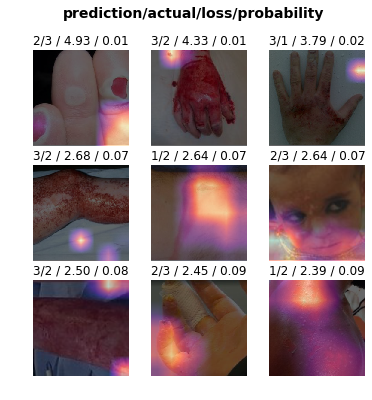

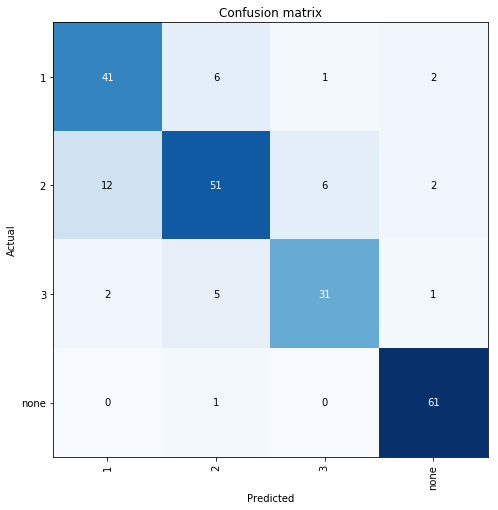

In [0]:
# Top Losses

interp = ClassificationInterpretation.from_learner(learn_4)
losses, idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(6, 6))
interp.plot_confusion_matrix(figsize=(7, 7))

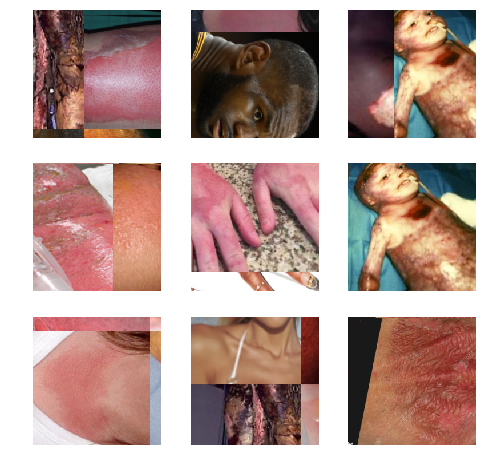

Learner(data=ImageDataBunch;

Train: LabelList (520 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,1,1,1
Path: /content/drive/My Drive/burn/burn_nosplit_final;

Valid: LabelList (222 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,1,1,1,3
Path: /content/drive/My Drive/burn/burn_nosplit_final;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [0]:
learn_4.show_multi_img_tfms()

## Comparison of accuracy results

In [0]:
print((time.time()-start)/60)

59.46304934422175


In [0]:
print(a, b, c, d ) #accuracies of default-fastai , mixup , cutmix , ricap respectively.

tensor(0.7793) tensor(0.8243) tensor(0.8063) tensor(0.8288)


Default vs mixup vs cutmix 

* with 5 epochs  ~ 10 min: tensor(0.6937) tensor(0.6486) tensor(0.6892)  i.e.  default > cutmix > mixup



* with 30 epochs  ~ 42 min : tensor(0.7838) tensor(0.8063) tensor(0.8063) i.e. default < mixup = cutmix



* with 60 epochs  ~ 51 min : tensor(0.8198) tensor(0.8153) tensor(0.8108) i.e default > mixup > cutmix


Default vs mixup vs cutmix  vs ricap


* with 5 epochs  ~ 14 min: tensor(0.7568) tensor(0.7252) tensor(0.7748) tensor(0.7117)  i.e.  cutmix >  default > mixup > ricap


* with 30 epochs  ~ 30 min: tensor(0.7928) tensor(0.8018) tensor(0.8108) tensor(0.8063))  i.e.   default <   mixup <  ricap < cutmix  


* with 60 epochs ~ 60 min: tensor(0.7793) tensor(0.8243) tensor(0.8063) tensor(0.8288) i.e. default < cutmix < mixup < ricap


Note: In the original paper [cutmix](https://github.com/clovaai/CutMix-PyTorch), number of epochs = 300 (however, it repeatedly disconnected on runnign on colab, so it was not shpwn here). This paper claims CutMix outperforms CutOut and MixUp techniques. Here we compare CutMix with MIxUp and aslo [RICAP](https://arxiv.org/abs/1811.09030). 

